## Data Pull


In [74]:
import os
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint

symbols = [
    "AMD", "NVDA", "AVGO", "MU", "TSM", "QCOM", "NET",
    "SNOW", "AMZN", "MSFT", "GOOGL", "DDOG", "ESTC", "DOCN", "PLTR", "MDB", 
    "OKTA", "CRWD", "ZS", "PANW", "S", "FTNT", "CYBR", "U",
    "TTD", "ROKU", "PINS", "SNAP", "PUBM", "CFLT", "GTLB", "FROG", "PD",
    "ORCL"


     # Additional Semiconductors & Hardware
    "INTC", "TXN", "LRCX", "KLAC", "AMAT", "MRVL", "MCHP", "SWKS", "QRVO",
    "ADI", "NXPI", "ON", "MPWR", "ENTG",
    
    # Cloud & Enterprise Software
    "CRM", "NOW", "ADBE", "WDAY", "TEAM", "ADSK", "INTU", "ZM", "VEEV",
    "DOCU", "SHOP", "TWLO", "HUBS", "BILL", "PATH", "DOMO",
    
    # Cybersecurity
    "CHKP", "FEYE", "SPLK", "TENB", "VRNS", "SAIL",
    
    # Digital Advertising & Media
    "TRADE", "MGNI", "RAMP", "META", "SPOT",
    
    # E-commerce & Payments
    "PYPL", "SQ", "EBAY", "WIX", "BIGC", "MELI",
    
    # SaaS & Productivity
    "SMAR", "PCTY", "RNG", "FIVN", "ASAN",
    
    # Infrastructure & Networking
    "CSCO", "ANET", "CIEN", "JNPR", "VMW"
]



def get_price_data(tickers, period="2y", max_missing=25):
           """Download and clean stock price data, save to CSV files"""
           try:
               print(f"Downloading data for {len(tickers)} stocks...")
               data = yf.download(tickers, period=period)

               # Clean missing data
               close_missing = data["Close"].isnull().sum()
               stocks_to_drop = close_missing[close_missing > max_missing].index.tolist()

               if stocks_to_drop:
                   print(f"Dropping {len(stocks_to_drop)} stocks with >{max_missing} missing values")
                   data = data.drop(stocks_to_drop, axis=1, level=1)

               # Save files
               data.to_csv("data.csv")
               close_returns = data["Close"].ffill().pct_change()
               close_returns.to_csv("close_returns.csv")

               # Simple summary
               remaining_stocks = len(data.columns.get_level_values(1).unique())
               print(f"Final dataset: {remaining_stocks} stocks")

               return data

           except Exception as e:
               print(f"Error downloading data: {e}")
               return None

       # Usage:
clean_data = get_price_data(symbols, max_missing=25)


C:\Users\Michael Gray\AppData\Local\Temp\ipykernel_13240\1571688257.py:45: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)
[                       0%                       ]

[*********************100%***********************]  90 of 90 completed

8 Failed downloads:
['FEYE', 'JNPR', 'TRADE', 'SQ', 'SMAR', 'SPLK', 'VMW', 'ORCLINTC']: YFPricesMissingError('possibly delisted; no price data found  (period=2y) (Yahoo error = "No data found, symbol may be delisted")')


Dropping 9 stocks with >25 missing values
Final dataset: 81 stocks


## PCA Clustering

In [75]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def simple_pca_analysis(returns_df, n_components=5):
    if 'Date' in returns_df.columns:
        returns_df = returns_df.set_index('Date')

    clean_returns = returns_df.select_dtypes(include=[np.number]).dropna()
    
    scaler = StandardScaler()
    scaled_returns = scaler.fit_transform(clean_returns)
    
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(scaled_returns)
    
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Cumulative variance explained: {pca.explained_variance_ratio_.cumsum()}")
    
    pca_df = pd.DataFrame(pca_result, 
                         index=clean_returns.index,
                         columns=[f'PC{i+1}' for i in range(n_components)])
    pca_df.to_csv("pca_results.csv")
    
    return pca, pca_df

close_returns = pd.read_csv("close_returns.csv", index_col=0) 
simple_pca_analysis(close_returns)



Explained variance ratio: [0.36531483 0.06670619 0.03409755 0.02556661 0.02195693]
Cumulative variance explained: [0.36531483 0.43202102 0.46611857 0.49168518 0.51364211]


(PCA(n_components=5),
                  PC1       PC2       PC3       PC4       PC5
 Date                                                        
 2023-09-27  2.219787 -0.727419  0.627095 -0.593006  1.318061
 2023-09-28  4.122817  0.731072 -0.331718  1.088191 -0.155461
 2023-09-29  1.861816 -1.121697 -0.328313  0.160129  0.741138
 2023-10-02  1.038718  0.077625  1.481746 -0.272137 -1.002678
 2023-10-03 -9.652626  2.148556 -0.809256 -0.105031  0.294569
 ...              ...       ...       ...       ...       ...
 2025-09-19 -0.014873 -0.925041  1.682033  0.155752 -1.003790
 2025-09-22  2.518345  0.829873 -2.013454 -2.286697  0.673287
 2025-09-23 -4.278871  2.339887  0.295372 -0.333716 -0.246848
 2025-09-24 -1.818143  0.984389 -1.407213 -0.149363 -0.531147
 2025-09-25 -2.747074 -0.162467  0.721877 -0.256596 -0.362617
 
 [501 rows x 5 columns])

Explained variance ratio: [0.36531483 0.06670619 0.03409755 0.02556656 0.02195771]
Cumulative variance explained: [0.36531483 0.43202102 0.46611857 0.49168513 0.51364284]


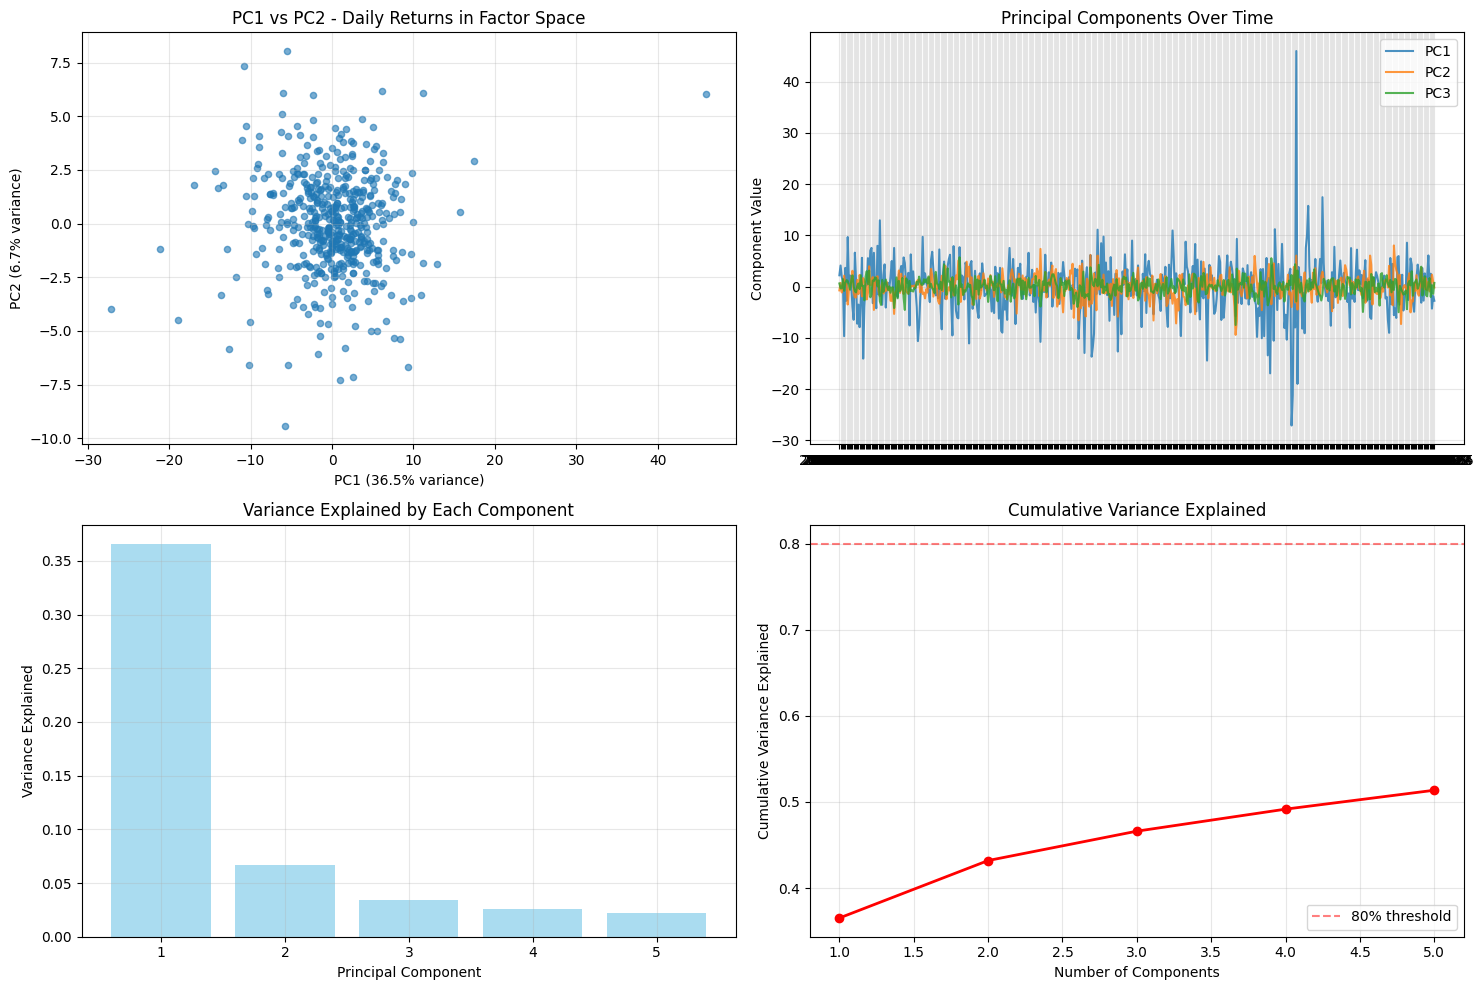

In [76]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


def pca_plotting(pca_model, pca_df):
    """Visualize PCA results with multiple plots"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. PC1 vs PC2 scatter plot
    ax1.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.6, s=20)
    ax1.set_xlabel(f'PC1 ({pca_model.explained_variance_ratio_[0]:.1%} variance)')
    ax1.set_ylabel(f'PC2 ({pca_model.explained_variance_ratio_[1]:.1%} variance)')
    ax1.set_title('PC1 vs PC2 - Daily Returns in Factor Space')
    ax1.grid(True, alpha=0.3)
    
    # 2. Time series of first 3 components
    ax2.plot(pca_df.index, pca_df['PC1'], label='PC1', alpha=0.8)
    ax2.plot(pca_df.index, pca_df['PC2'], label='PC2', alpha=0.8)
    ax2.plot(pca_df.index, pca_df['PC3'], label='PC3', alpha=0.8)
    ax2.set_title('Principal Components Over Time')
    ax2.set_ylabel('Component Value')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Individual variance explained
    components = range(1, len(pca_model.explained_variance_ratio_) + 1)
    ax3.bar(components, pca_model.explained_variance_ratio_, alpha=0.7, color='skyblue')
    ax3.set_xlabel('Principal Component')
    ax3.set_ylabel('Variance Explained')
    ax3.set_title('Variance Explained by Each Component')
    ax3.grid(True, alpha=0.3)
    
    # 4. Cumulative variance explained
    ax4.plot(components, pca_model.explained_variance_ratio_.cumsum(), 'ro-', linewidth=2)
    ax4.set_xlabel('Number of Components')
    ax4.set_ylabel('Cumulative Variance Explained')
    ax4.set_title('Cumulative Variance Explained')
    ax4.grid(True, alpha=0.3)
    ax4.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='80% threshold')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()

# Run your PCA analysis
close_returns = pd.read_csv("close_returns.csv", index_col=0)
pca_model, pca_df = simple_pca_analysis(close_returns)
pca_plotting(pca_model, pca_df)

In [77]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def cluster_stocks_with_pca(pca_model, stock_names, n_clusters=5, n_components=3):
    """
    Cluster stocks based on their loadings on the first few principal components
    """
    loadings = pca_model.components_[:n_components].T  # Shape: (n_stocks, n_components)
    
    # Create DataFrame for easier handling
    loadings_df = pd.DataFrame(
        loadings, 
        index=stock_names, 
        columns=[f'PC{i+1}' for i in range(n_components)]
    )
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(loadings)
    
    # Add cluster labels to the DataFrame
    loadings_df['Cluster'] = cluster_labels
    
    # Print cluster assignments
    print(f"Stock Clusters (using first {n_components} PCs):")
    print("="*50)
    for i in range(n_clusters):
        cluster_stocks = loadings_df[loadings_df['Cluster'] == i].index.tolist()
        print(f"Cluster {i} ({len(cluster_stocks)} stocks): {cluster_stocks}")
    
    return loadings_df, kmeans

pca_model, pca_df = simple_pca_analysis(close_returns)
stock_names = close_returns.columns.tolist()
cluster_results, kmeans_model = cluster_stocks_with_pca(
    pca_model, stock_names, n_clusters=6, n_components=3
)



Explained variance ratio: [0.36531483 0.06670619 0.03409755 0.02556608 0.02195779]
Cumulative variance explained: [0.36531483 0.43202102 0.46611857 0.49168465 0.51364244]
Stock Clusters (using first 3 PCs):
Cluster 0 (18 stocks): ['ADBE', 'AMZN', 'CIEN', 'CRWD', 'CYBR', 'DDOG', 'FTNT', 'GOOGL', 'INTU', 'MDB', 'MELI', 'NET', 'NOW', 'PANW', 'PLTR', 'SNOW', 'SPOT', 'ZS']
Cluster 1 (27 stocks): ['ADSK', 'BILL', 'CFLT', 'CHKP', 'CRM', 'CSCO', 'DOCN', 'DOCU', 'DOMO', 'ESTC', 'FROG', 'GTLB', 'HUBS', 'MGNI', 'OKTA', 'PATH', 'PINS', 'RAMP', 'S', 'SHOP', 'TEAM', 'TENB', 'TTD', 'TWLO', 'VRNS', 'WDAY', 'WIX']
Cluster 2 (8 stocks): ['AMAT', 'AMD', 'KLAC', 'LRCX', 'MPWR', 'MRVL', 'MU', 'QCOM']
Cluster 3 (8 stocks): ['ADI', 'ENTG', 'MCHP', 'NXPI', 'ON', 'QRVO', 'SWKS', 'TXN']
Cluster 4 (6 stocks): ['ANET', 'AVGO', 'META', 'MSFT', 'NVDA', 'TSM']
Cluster 5 (14 stocks): ['ASAN', 'BIGC', 'EBAY', 'FIVN', 'PCTY', 'PD', 'PUBM', 'PYPL', 'RNG', 'ROKU', 'SNAP', 'U', 'VEEV', 'ZM']


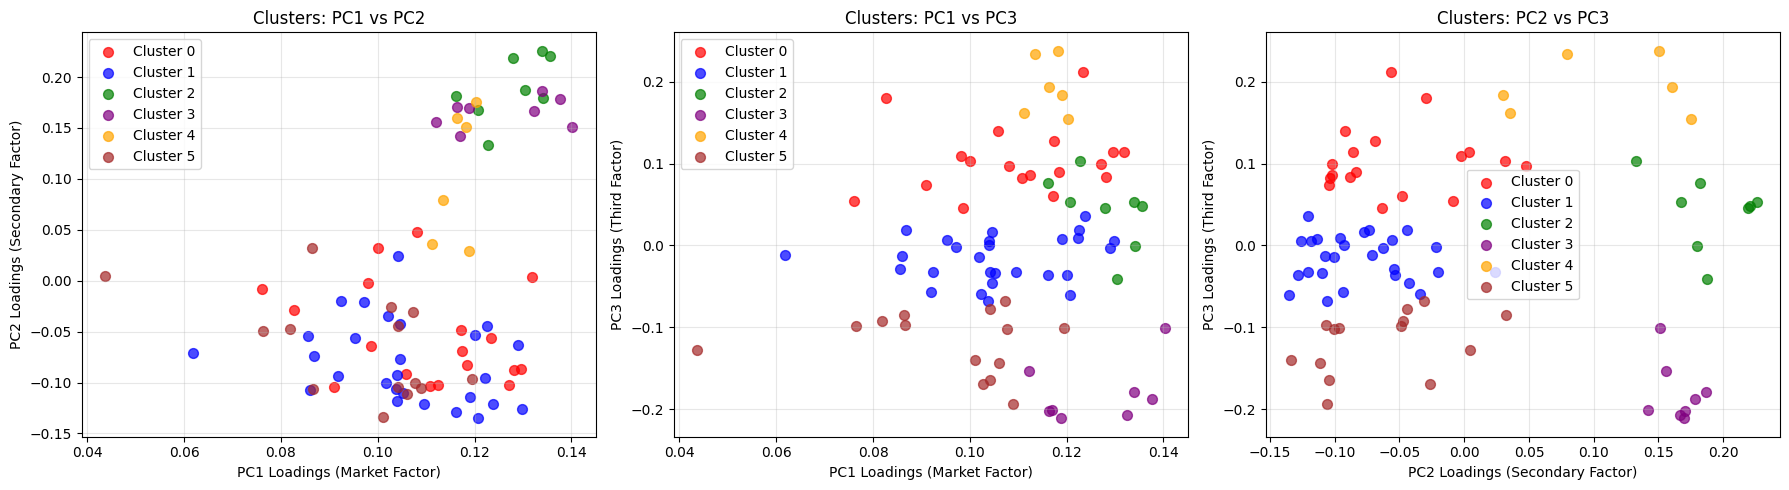

In [78]:
def visualize_stock_clusters(loadings_df, n_components=3):
    """
    Visualize stock clusters in PCA loading space
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray']
    n_clusters = loadings_df['Cluster'].nunique()
    
    # PC1 vs PC2
    for i in range(n_clusters):
        mask = loadings_df['Cluster'] == i
        axes[0].scatter(loadings_df.loc[mask, 'PC1'], 
                       loadings_df.loc[mask, 'PC2'],
                       c=colors[i], label=f'Cluster {i}', alpha=0.7, s=50)
    axes[0].set_xlabel('PC1 Loadings (Market Factor)')
    axes[0].set_ylabel('PC2 Loadings (Secondary Factor)')
    axes[0].set_title('Clusters: PC1 vs PC2')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # PC1 vs PC3
    for i in range(n_clusters):
        mask = loadings_df['Cluster'] == i
        axes[1].scatter(loadings_df.loc[mask, 'PC1'], 
                       loadings_df.loc[mask, 'PC3'],
                       c=colors[i], label=f'Cluster {i}', alpha=0.7, s=50)
    axes[1].set_xlabel('PC1 Loadings (Market Factor)')
    axes[1].set_ylabel('PC3 Loadings (Third Factor)')
    axes[1].set_title('Clusters: PC1 vs PC3')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # PC2 vs PC3
    for i in range(n_clusters):
        mask = loadings_df['Cluster'] == i
        axes[2].scatter(loadings_df.loc[mask, 'PC2'], 
                       loadings_df.loc[mask, 'PC3'],
                       c=colors[i], label=f'Cluster {i}', alpha=0.7, s=50)
    axes[2].set_xlabel('PC2 Loadings (Secondary Factor)')
    axes[2].set_ylabel('PC3 Loadings (Third Factor)')
    axes[2].set_title('Clusters: PC2 vs PC3')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize the clusters
visualize_stock_clusters(cluster_results)